In [68]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_integral import fitting_2_layer, integral_lapse_dlnp_hydrostatic, get_temp_const_lapse, \
    get_temp_mod_parcel_lapse, get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
from jobs.theory_lapse.scripts.lapse_fitting import processed_dir, processed_file_name, exp_name

n_exp = len(exp_name)

In [5]:
# Load in data
ds = [xr.open_dataset(os.path.join(processed_dir[i], processed_file_name)) for i in range(n_exp)]
co2_vals = [get_co2_multiplier(i) for i in exp_name]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))

In [6]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
land_frac = xr.open_dataset(invariant_data_path).LANDFRAC
land_frac = land_frac.reindex_like(ds, method="nearest", tolerance=0.01)
land_frac_thresh = 0.1
lsm = (land_frac > land_frac_thresh)

### Valid Regions
Valid regions were those for which the fitting was able to fit, and is mostly land. Mountanous regions have LCL above the FT level. While some high latitude regions have LCL below the surface.

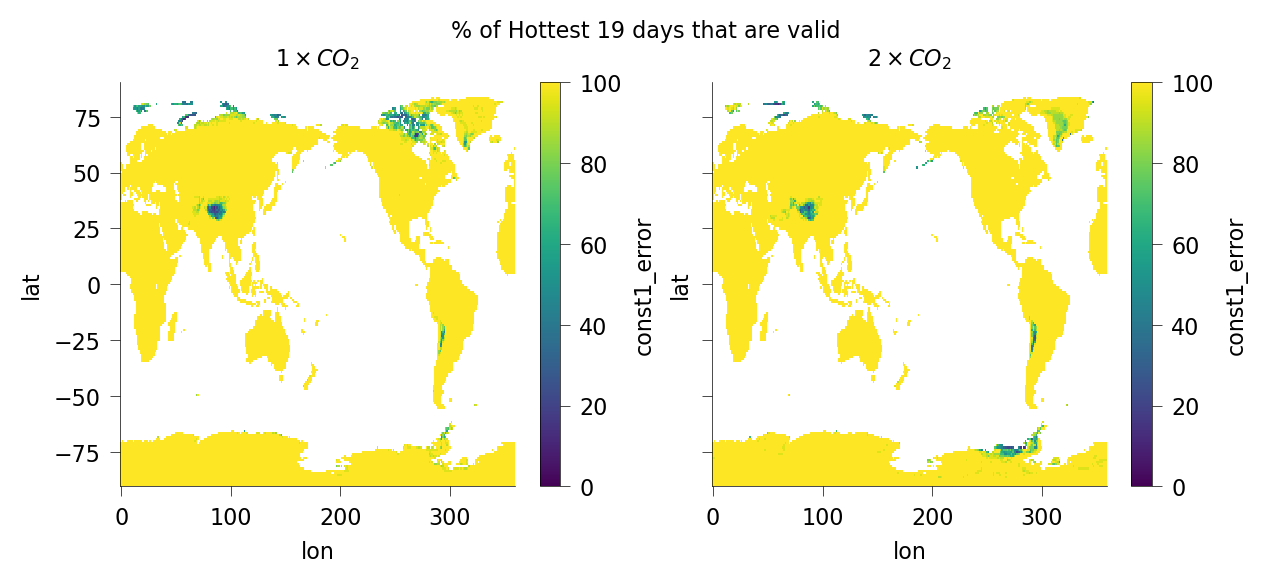

In [26]:
valid = (~np.isnan(ds.const1_error).isel(layer=0))
valid_all = (np.isnan(ds.const1_error).isel(layer=0).sum(dim=['sample', 'co2']) == 0)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for i in range(n_exp):
    (valid.sum(dim='sample') / ds.sample.size * 100).isel(co2=i).where(lsm).plot(ax=ax[i], vmin=0, vmax=100)
    # Show regions where LCL is below surface
    # ((ds.p_lcl > ds.PREFHT).isel(co2=i).sum(dim='sample') / ds.sample.size * 100).where(lsm).plot(ax=ax[i], vmin=0, vmax=20)
    ax[i].set_title(f'${int(ds.co2[i])} \\times CO_2$')
fig.suptitle(f"% of Hottest {ds.sample.size} days that are valid", y=1)
# fig.suptitle(f"% of Hottest {ds.sample.size} days that have LCL below REFHT", y=1)
update_fontsize(fig, 10)
plt.show()


### Which fit is best?
Below I say that the `mod_parcel2` fit is acceptable if it has lower error than 25% and has a lower error than `const2`. Then I say `const2` is a reasonable fit if it has error less than 25% and is the lowest error. The remainder I show in the third plot.

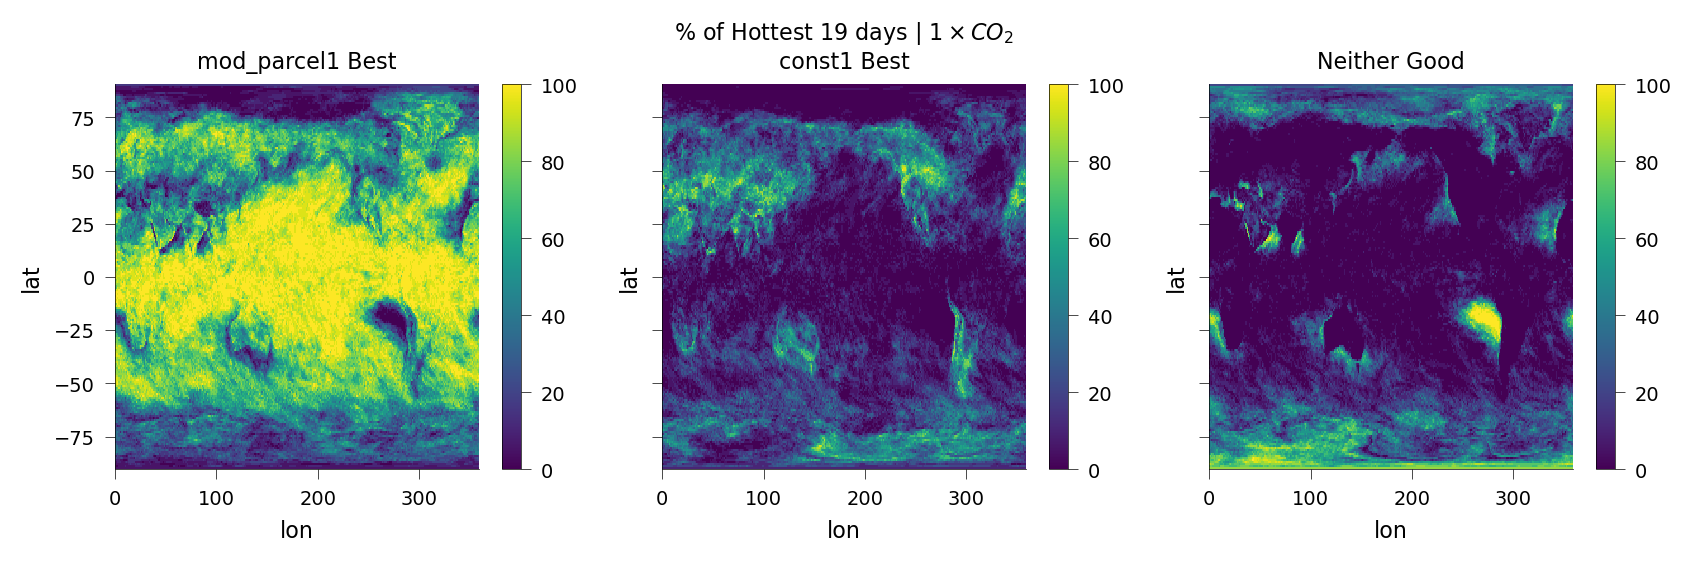

In [29]:
error_thresh = 0.25
error_thresh2 = 0.1
# const_multiplier = 0.9
const_multiplier = 1
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(ds.mod_parcel1_error.sum(dim='layer') / ds.mod_parcel1_integral.sum(dim='layer'))

mask_fit = {'mod_parcel1':  (mod_parcel1_error < const_multiplier * const1_error) & (mod_parcel1_error < error_thresh)}
mask_fit['mod_parcel1'] = mask_fit['mod_parcel1'] | (mod_parcel1_error < error_thresh2)
mask_fit['const1'] = ~mask_fit['mod_parcel1'] & (const1_error < error_thresh)
mask_fit['bad'] = ~mask_fit['mod_parcel1'] & ~mask_fit['const1']


co2_ind = 0
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)
(mask_fit['mod_parcel1'].where(valid).sum(dim='sample').isel(co2=co2_ind) / ds.sample.size * 100).plot(ax=ax[0], vmin=0, vmax=100)
(mask_fit['const1'].where(valid).sum(dim='sample').isel(co2=co2_ind)/ds.sample.size*100).plot(ax=ax[1], vmin=0, vmax=100)
(mask_fit['bad'].where(valid).sum(dim='sample').isel(co2=co2_ind)/ds.sample.size*100).plot(ax=ax[2], vmin=0, vmax=100)
ax[0].set_title('mod_parcel1 Best')
ax[1].set_title(f'% of Hottest {ds.sample.size} days | ${int(ds.co2[co2_ind])} \\times CO_2$\nconst1 Best')
ax[2].set_title('Neither Good')
plt.show()

### Initial analysis for spatial variation within a climate
Below I create 2 figures to allow comparison between the spatial variation of `TREFHT` with the lapse rate, LCL height and $T_{FT}$. These are the variables that influence `TREFHT` through a vertical profile decomposition.

In [30]:
def get_var_av(var, n_lat_av=50, mask=None, av_dim=None):
    """Compute latitude-smoothed mean of a variable, ensuring no NaN latitudes.

    Args:
        var (xr.DataArray): Variable with dimensions ('lat', 'lon', 'sample', ...).
        n_lat_av (int, optional): Number of latitude points for rolling mean. Defaults to 30.
        mask (xr.DataArray, optional): Land-sea mask (True where valid). Defaults to None.

    Returns:
        xr.DataArray: Latitude-smoothed mean with all latitudes filled.
    """
    n_pad = n_lat_av // 2  # half-window size

    # Apply mask if provided
    if mask is not None:
        var = var.where(mask)

    # Take mean over non-lat dims
    if av_dim is None:
        av_dim = [d for d in var.dims if d not in ['lat']]
    var_latmean = var.median(dim=av_dim)

    # Fill NaNs along latitude by nearest interpolation
    var_filled = var_latmean.interpolate_na(dim="lat", method="nearest", fill_value="extrapolate")

    # Pad with edge values to avoid NaNs at the ends
    var_padded = var_filled.pad(lat=(n_pad, n_pad), mode="edge")

    # Apply rolling mean and trim padding
    var_av = var_padded.rolling(lat=n_lat_av, center=True).mean().isel(lat=slice(n_pad, -n_pad))

    return var_av


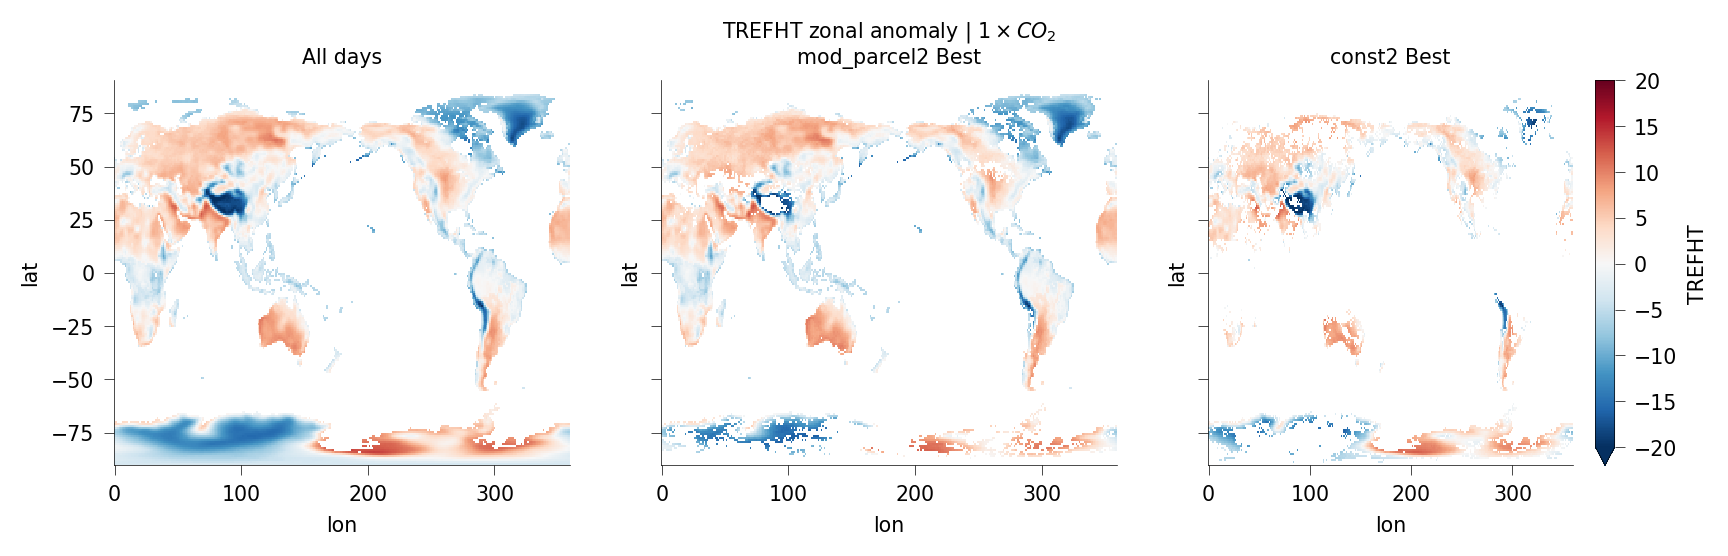

In [35]:
co2_ind = 0
n_days_plot = 5
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)

(ds.TREFHT.mean(dim='sample') - get_var_av(ds.TREFHT, mask=lsm, av_dim=['sample', 'lon'])
 ).isel(co2=co2_ind).where(lsm).plot(ax=ax[0], vmax=20, add_colorbar=False)
for i, key in enumerate(['mod_parcel1', 'const1']):
    show_reg = lsm & (mask_fit[key].isel(co2=co2_ind).sum(dim='sample')>n_days_plot)
    (ds.TREFHT.where(mask_fit[key]).mean(dim='sample') - get_var_av(ds.TREFHT, mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
     ).isel(co2=co2_ind).where(show_reg).plot(ax=ax[1+i], vmax=20, add_colorbar=i==1)
ax[0].set_title('All days')
ax[1].set_title(f'TREFHT zonal anomaly | ${int(ds.co2[co2_ind])} \\times CO_2$\nmod_parcel2 Best')
ax[2].set_title('const2 Best')
update_fontsize(fig, 8)
plt.show()

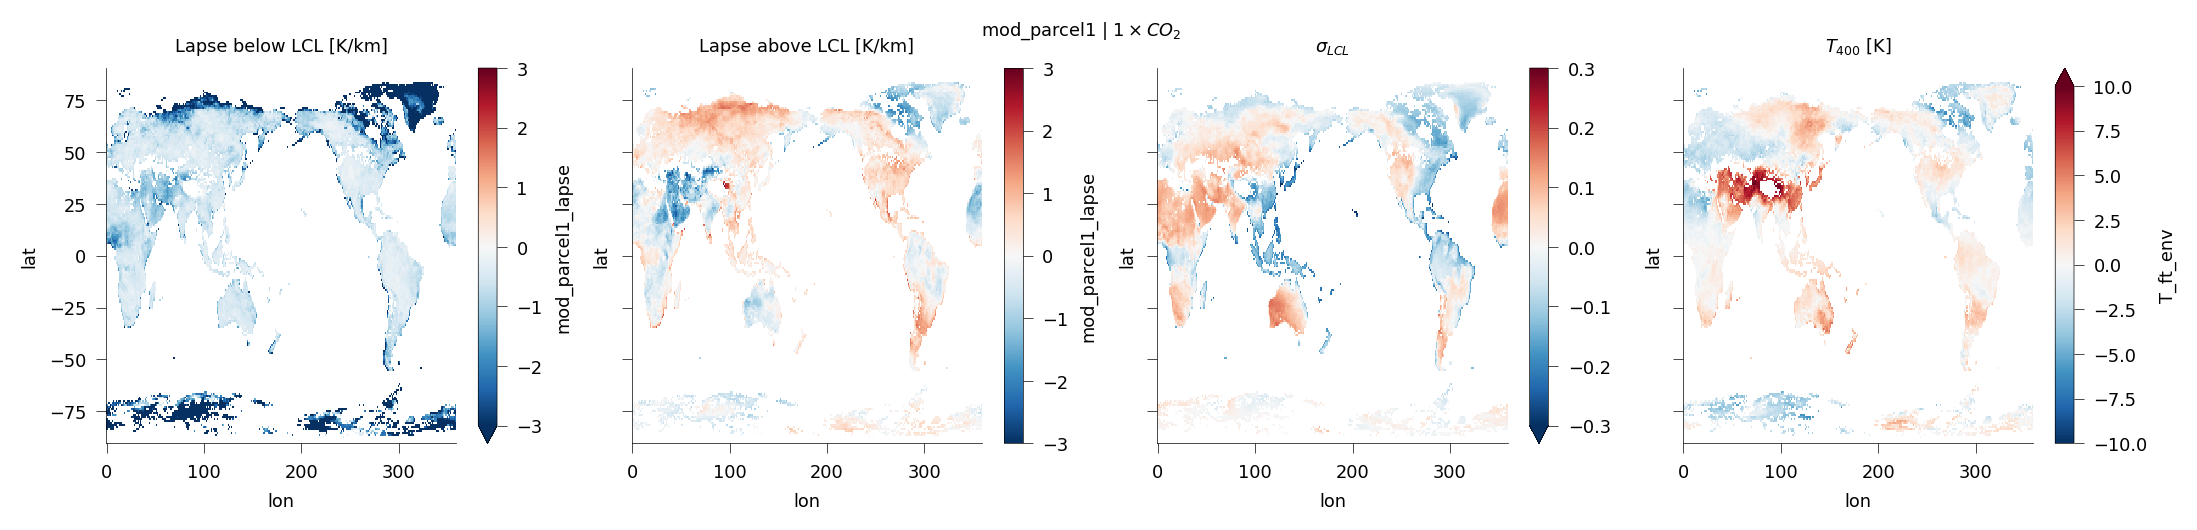

In [36]:
key = 'mod_parcel1'
co2_ind = 0
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
fig_resize(fig, 13)
for i in range(ds.layer.size):
    var = ds[f"{key}_lapse"].isel(layer=i).where(mask_fit[key]).mean(dim='sample')
    if i == 0:
        # var_av = ds[f"{key}_lapse"].isel(layer=i).where(mask_fit[key]).isel(co2=co2_ind).where(lsm).median()
        var_av = lapse_dry * 1000
    else:
        var_av = get_var_av(ds[f"{key}_lapse"].isel(layer=i), mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
    var = var - var_av
    show_reg = lsm & (mask_fit[key].isel(co2=co2_ind).sum(dim='sample')>n_days_plot)
    var.isel(co2=co2_ind).where(show_reg).plot(ax=ax[i], vmax=3)
var = ds[f"{key}_p_lcl" if '2' in key else 'p_lcl'] / ds.PREFHT
var = -var.where(mask_fit[key]).mean(dim='sample') + get_var_av(var, mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
var.isel(co2=co2_ind).where(show_reg).plot(ax=ax[2], vmax=0.3)

var = ds.T_ft_env
var = var.where(mask_fit[key]).mean(dim='sample') - get_var_av(var, mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
var.isel(co2=co2_ind).where(show_reg).plot(ax=ax[3], vmax=10)

ax[0].set_title('Lapse below LCL [K/km]')
ax[1].set_title('Lapse above LCL [K/km]')
ax[2].set_title('$\sigma_{LCL}$')
ax[3].set_title(f'$T_{"{"+str(int(ds.p_ft/100))+"}"}$ [K]')
fig.suptitle(f'{key} | ${int(ds.co2[co2_ind])} \\times CO_2$')
update_fontsize(fig, 9)
plt.show()

### Initial analysis for change with warming
Below I repeat the above plots, but for the change with warming.

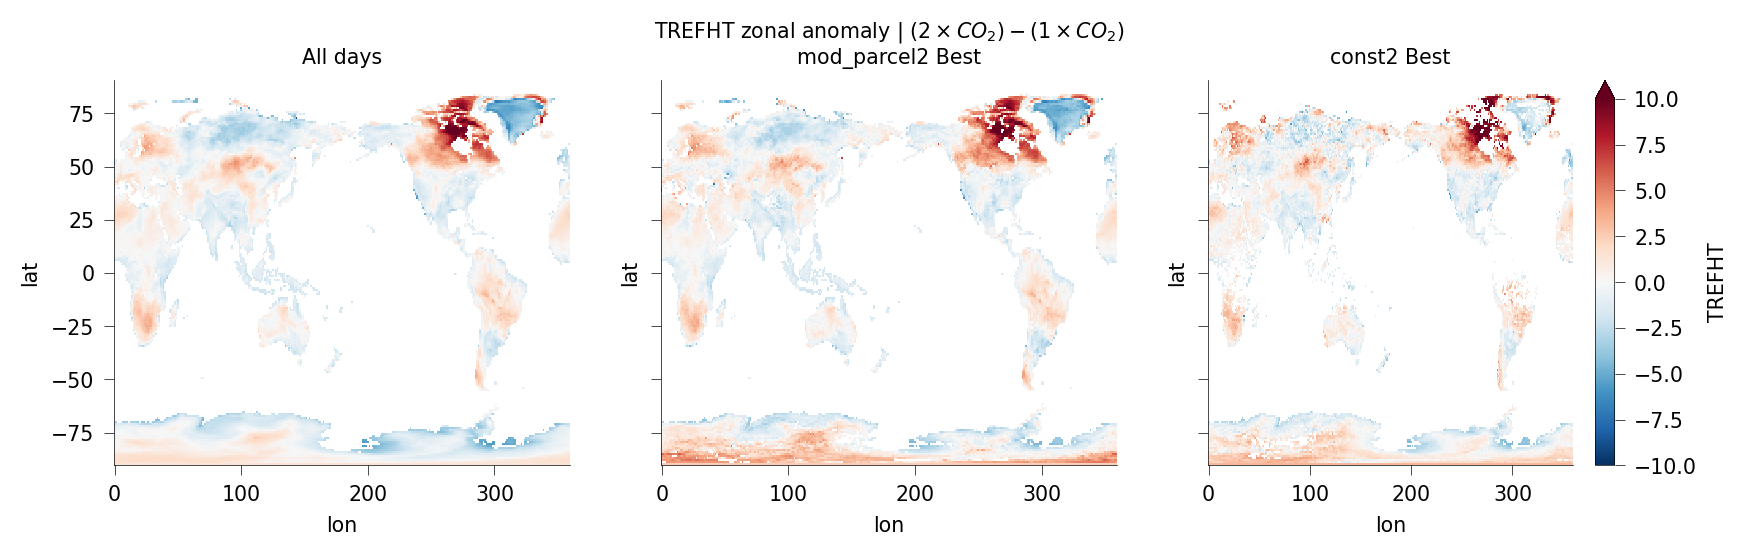

In [38]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)
var = ds.TREFHT.mean(dim='sample')
var = var.isel(co2=1) - var.isel(co2=0)
var = (var - get_var_av(var, mask=lsm))
var.where(lsm).plot(ax=ax[0], vmax=10, add_colorbar=False)


for i, key in enumerate(['mod_parcel1', 'const1']):
    var = ds.TREFHT.where(mask_fit[key]).mean(dim='sample')
    var = var.isel(co2=1) - var.isel(co2=0)
    show_reg = lsm & (mask_fit[key].isel(co2=0).sum(dim='sample')>n_days_plot) & (mask_fit[key].isel(co2=1).sum(dim='sample')>n_days_plot)
    (var - get_var_av(var, mask=show_reg)).where(lsm).plot(ax=ax[1+i], vmax=10, add_colorbar=i==1)
    # (ds.TREFHT.where(mask_fit[key]).mean(dim='sample') - get_var_av(ds.TREFHT, mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
    #  ).isel(co2=co2_ind).where(show_reg).plot(ax=ax[1+i], vmax=20, add_colorbar=False)
ax[0].set_title('All days')
ax[1].set_title(f'TREFHT zonal anomaly | $({int(ds.co2[1])} \\times CO_2) - ({int(ds.co2[0])} \\times CO_2)$\nmod_parcel2 Best')
ax[2].set_title('const2 Best')
update_fontsize(fig, 8)
plt.show()

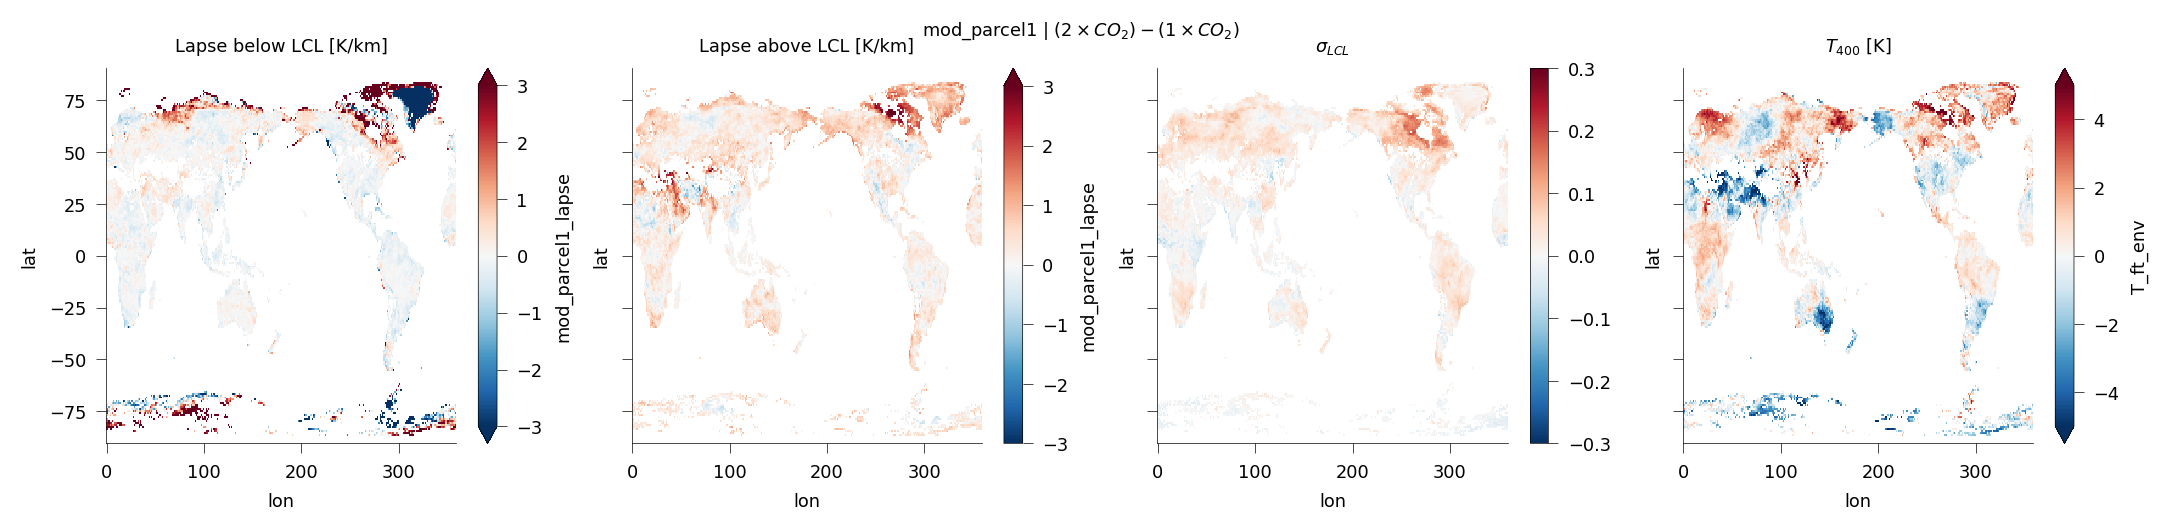

In [39]:
key = 'mod_parcel1'
show_anom = False
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
fig_resize(fig, 13)
show_reg = lsm & (mask_fit[key].isel(co2=0).sum(dim='sample')>n_days_plot)  & (mask_fit[key].isel(co2=1).sum(dim='sample')>n_days_plot)
for i in range(ds.layer.size):
    var = ds[f"{key}_lapse"].isel(layer=i).where(mask_fit[key]).mean(dim='sample')
    var = var.isel(co2=1) - var.isel(co2=0)
    if show_anom and (i == 1):
        var = var - get_var_av(var, mask=show_reg)
    var.where(show_reg).plot(ax=ax[i], vmax=3)

var = ds[f"{key}_p_lcl" if '2' in key else 'p_lcl'] / ds.PREFHT
var = -var.where(mask_fit[key]).mean(dim='sample')
var = var.isel(co2=1) - var.isel(co2=0)
if show_anom:
    var = var - get_var_av(var, mask=show_reg)
var.where(show_reg).plot(ax=ax[2], vmax=0.3)

var = ds.T_ft_env.where(mask_fit[key]).mean(dim='sample')
var = var.isel(co2=1) - var.isel(co2=0)
if show_anom:
    var = var - get_var_av(var, mask=show_reg)
else:
    var = var - var.where(lsm).median()
var.where(show_reg).plot(ax=ax[3], vmax=5)

ax[0].set_title('Lapse below LCL [K/km]')
ax[1].set_title('Lapse above LCL [K/km]')
ax[2].set_title('$\sigma_{LCL}$')
ax[3].set_title(f'$T_{"{"+str(int(ds.p_ft/100))+"}"}$ [K]')
fig.suptitle(f'{key} | $({int(ds.co2[1])} \\times CO_2) - ({int(ds.co2[0])} \\times CO_2)$')
update_fontsize(fig, 9)
plt.show()

### Zonal Mean Scaling Factor
Below we look at why the hottest 19 days warm more at some latitudes than others, through a linear breakdown of the physical mechanisms.

We can only consider a small latitude range because otherwise, the difference between reference values are large and get large non-linear contributions.

In [189]:
ds['rh_REFHT'] = ds.QREFHT / sphum_sat(ds.TREFHT, ds.PREFHT)
ds_sf = ds[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']]
error = {
    key: np.abs(ds[f'{key}1_error'].sum(dim='layer') / ds[f'{key}1_integral'].sum(dim='layer') * 100)
    for key in ['mod_parcel', 'const']}
mask_use = lsm & (error['mod_parcel'] < 25) & (error['mod_parcel'] < error['const'])
#mask_use = mask_use * 0 + 1

ds_sf = ds_sf.where(mask_use).mean(dim=['sample', 'lon']).sel(lat=slice(70, 90))
ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry
ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1) / 1000
ds_sf = ds_sf.drop_vars(['mod_parcel1_lapse', 'layer'])
ds_sf = ds_sf.transpose('co2', 'lat')
ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft'})
for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
    ds_sf[key + '_ref'] = ds_sf[key].median(dim='lat')
    if 'lapse' in key:
        ds_sf[key + '_ref'] = np.abs(ds_sf[key + '_ref'] * 0)  # for lapse, ref value is 0
    elif key != 'temp_surf':
        # For rh and pressure, keep at colder climate ref
        ds_sf[key + '_ref'] = ds_sf[key + '_ref'] * 0 + ds_sf[key + '_ref'].isel(co2=0)

In [190]:
def apply_scale_factor(ds, p_ft=float(ds_sf.p_ft)):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds["temp_surf_ref"],  # (co2)
        ds["temp_surf"],  # (co2, quant)
        ds["rh_surf_ref"],  # (co2)
        ds["rh_surf"],  # (co2, quant)
        ds["temp_ft"],  # (co2, quant)
        ds["lapse_mod_D"],  # (co2, quant)
        ds["lapse_mod_M"],  # (co2, quant)
        p_ft,  # (co2) or scalar
        ds["p_surf_ref"],  # (co2) or scalar
        ds["p_surf"],  # (co2, quant) or None
        ds["lapse_mod_D_ref"],  # (co2) or None
        ds["lapse_mod_M_ref"],  # (co2) or None
        kwargs=dict(
            temp_surf_lcl_calc=300
        ),
        input_core_dims=[
            ["co2"],  # temp_surf_ref
            ["co2", "lat"],
            ["co2"],
            ["co2", "lat"],
            ["co2", "lat"],
            ["co2", "lat"],
            ["co2", "lat"],
            [],  # p_ft_ref
            ["co2"],  # p_surf_ref
            ["co2", "lat"],
            ["co2"],
            ["co2"],
        ],
        output_core_dims=[
            ["lat"],  # result array
            ["lat"],
            []  # dict-of-arrays (broadcast to co2)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )
    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds['temp_surf'].isel(co2=1) - ds['temp_surf'].isel(co2=0)
                                ) / (ds['temp_surf_ref'].isel(co2=1) - ds['temp_surf_ref'].isel(co2=0))}
    # Determine all dict keys from the first element
    keys = list(out_dict.item().keys())

    for key in keys:
        dict_ds[key] = xr.DataArray(
            out_dict.item()[key],
            coords=dict(lat=ds.lat),
            dims="lat",
        )

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})
    # ds_out = ds_out
    return ds_out

In [191]:
ds_out = apply_scale_factor(ds_sf)

In [196]:
style_map = {
    # --- reference change (dashed) ---
    "r_ref_change": ("C0", "--"),
    "p_surf_ref_change": ("C4", "--"),
    "lapse_mod_D_ref_change": ("C1", "--"),
    "lapse_mod_M_ref_change": ("C3", "--"),

    # --- change (solid) ---
    "temp_ft_change": ("C2", "-"),
    "r_change": ("C0", "-"),
    "lapse_mod_D_change": ("C1", "-"),
    "lapse_mod_M_change": ("C3", "-"),
    "p_surf_change": ("C4", "-"),
    "error_av_change": ("C5", "-"),

    # --- anomalies (dotted) ---
    "temp_anom": ("C2", ":"),
    "r_anom": ("C0", ":"),
    "lapse_mod_D_anom": ("C1", ":"),
    "lapse_mod_M_anom": ("C3", ":"),
    "p_surf_anom": ("C4", ":"),

    # nl
    "nl_residual": ("C5", "-."),

    # sf
    "scale_factor": ('k', "-"),
    "scale_factor_linear": ('k', ":"),
    "scale_factor_sum": ('k', "--")
}
for key2 in [k for k in style_map if "nl" not in k and "ref" not in k]:
    style_map['nl_' + key2] = (style_map[key2][0], '-.')

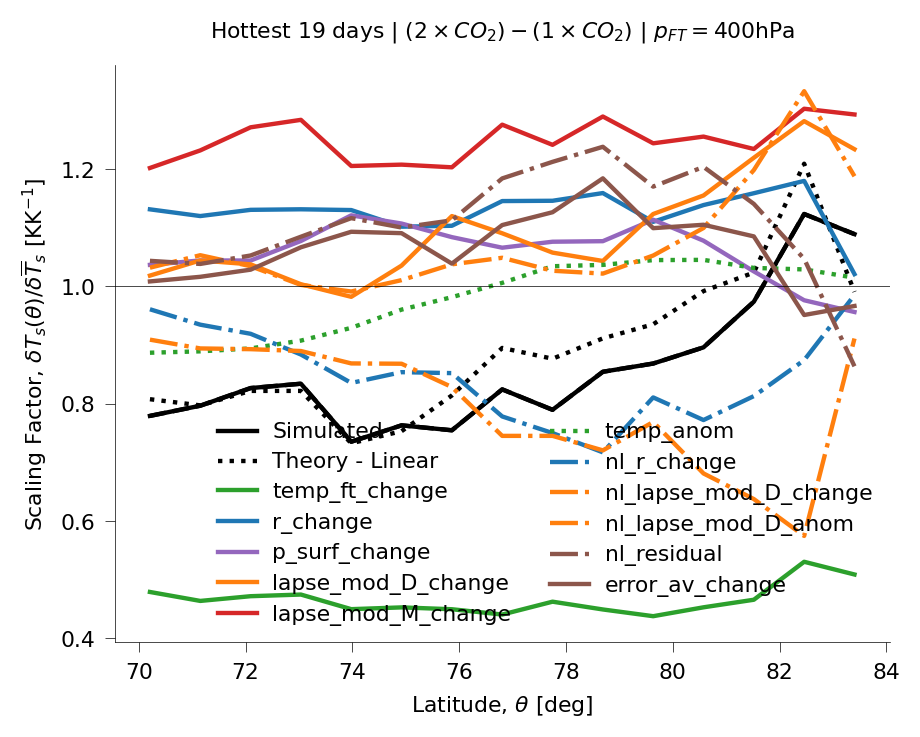

In [197]:
show_non_linear = True

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for key in ['', '_sum', '_linear']:
    ax.plot(ds_out.lat, ds_out[f"scale_factor{key}"],
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label={'': 'Simulated', '_linear': 'Theory - Linear', '_sum': None}[key])
for key in ds_out:
    var = ds_out[key]
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        # Combine non-linear and linear into single mechanism on plot
        if (not show_non_linear) and ('residual' not in key):
            var = var + ds_out[key.replace('nl_', '')] - 1
            key = key.replace('nl_', '')
    elif (not show_non_linear) and ('error_av' not in key):
        continue
    if np.abs(var - 1).max() < 0.1:
        continue
    ax.plot(ds_out.lat, var, label=key,
            color=style_map[key][0], linestyle=style_map[key][1])
update_linewidth(fig)
ax.legend(ncol=2)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel('Latitude, $\\theta$ [deg]')
ax.set_ylabel("Scaling Factor, $\delta T_s(\\theta)/\delta \overline{T}_s$ [KK$^{-1}$]")
ax.set_title(
    f"Hottest {ds.sample.size} days | $({int(ds.co2[1])} \\times CO_2) - ({int(ds.co2[0])} \\times CO_2)$ | "
    f"$p_{'{FT}'} = {ds_sf.p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig, 5)
plt.show()

In [305]:
ds_sf = ds[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']]
error = {
    key: np.abs(ds[f'{key}1_error'].sum(dim='layer') / ds[f'{key}1_integral'].sum(dim='layer') * 100)
    for key in ['mod_parcel', 'const']}
mask_use = lsm & (error['mod_parcel'] < 25) & (error['mod_parcel'] < error['const'])
#mask_use = mask_use * 0 + 1

ds_sf = ds_sf.where(mask_use).mean(dim=['sample'])
ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry
ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1) / 1000
ds_sf = ds_sf.drop_vars(['mod_parcel1_lapse', 'layer'])
ds_sf = ds_sf.transpose('co2', 'lon', 'lat')
ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft'})
for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
    ds_sf[key + '_ref'] = get_var_av(ds_sf[key], 50, av_dim='lon')
    if 'lapse' in key:
        ds_sf[key + '_ref'] = np.abs(ds_sf[key + '_ref'] * 0)  # for lapse, ref value is 0
    elif key != 'temp_surf':
        # For rh and pressure, keep at colder climate ref
        ds_sf[key + '_ref'] = ds_sf[key + '_ref'] * 0 + ds_sf[key + '_ref'].isel(co2=0)

ds_sf['scale_factor'] = (ds_sf['temp_surf'].isel(co2=1) - ds_sf['temp_surf'].isel(co2=0)
                         ) / (ds_sf['temp_surf_ref'].isel(co2=1) - ds_sf['temp_surf_ref'].isel(co2=0))

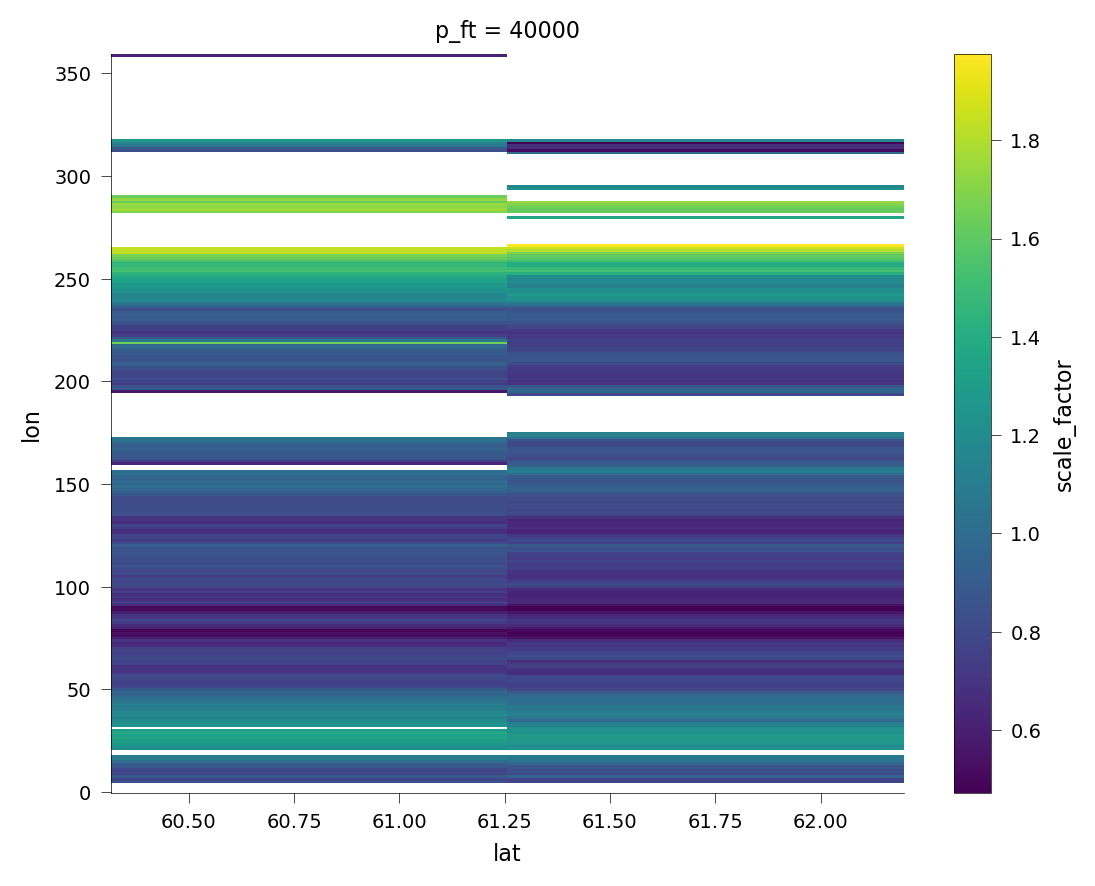

In [315]:
ds_sf.scale_factor.sel(lat=slice(60, 62)).plot()

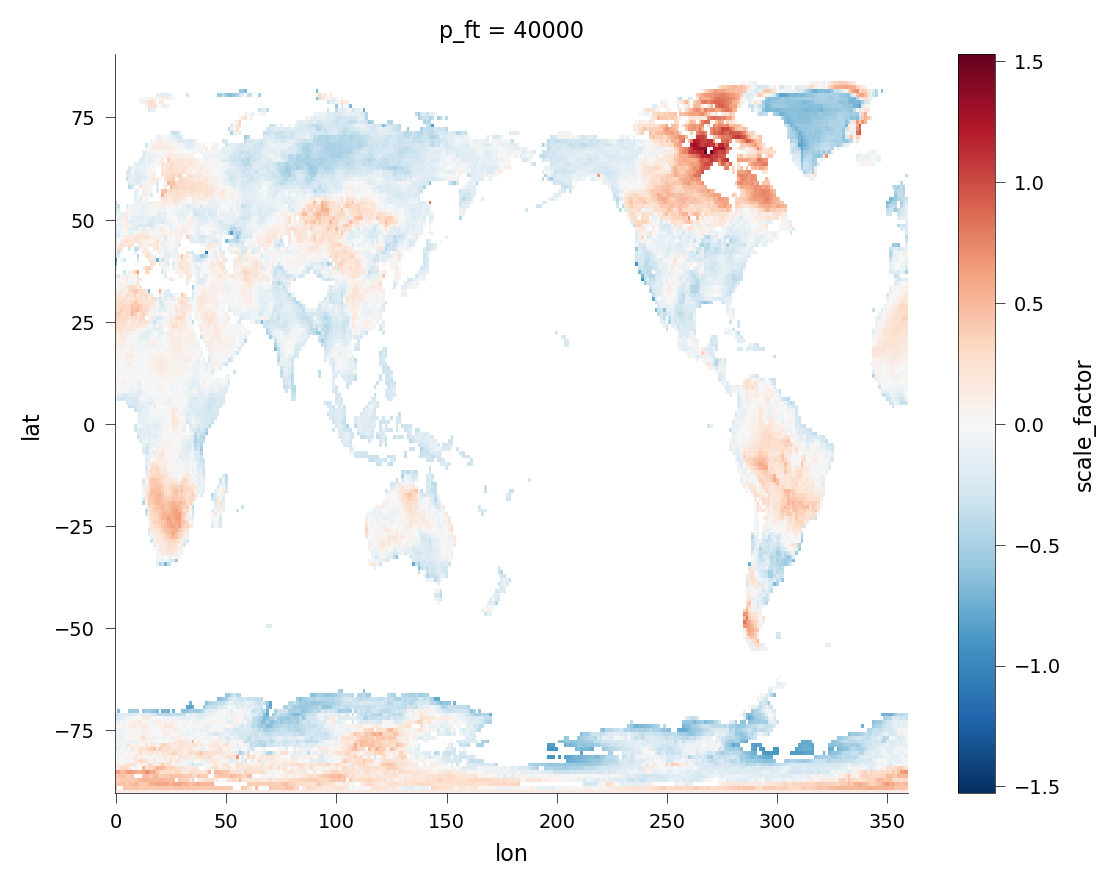

In [306]:
(ds_sf.scale_factor.transpose()-1).plot()

In [240]:
def apply_scale_factor_spatial(ds, p_ft=float(ds_sf.p_ft)):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds["temp_surf_ref"],  # (co2)
        ds["temp_surf"],  # (co2, quant)
        ds["rh_surf_ref"],  # (co2)
        ds["rh_surf"],  # (co2, quant)
        ds["temp_ft"],  # (co2, quant)
        ds["lapse_mod_D"],  # (co2, quant)
        ds["lapse_mod_M"],  # (co2, quant)
        p_ft,  # (co2) or scalar
        ds["p_surf_ref"],  # (co2) or scalar
        ds["p_surf"],  # (co2, quant) or None
        ds["lapse_mod_D_ref"],  # (co2) or None
        ds["lapse_mod_M_ref"],  # (co2) or None
        kwargs=dict(
            temp_surf_lcl_calc=300
        ),
        input_core_dims=[
            ["co2"],  # temp_surf_ref
            ["co2", "lon"],
            ["co2"],
            ["co2", "lon"],
            ["co2", "lon"],
            ["co2", "lon"],
            ["co2", "lon"],
            [],  # p_ft_ref
            ["co2"],  # p_surf_ref
            ["co2", "lon"],
            ["co2"],
            ["co2"],
        ],
        output_core_dims=[
            ["lon"],  # result array
            ["lon"],
            []  # dict-of-arrays (broadcast to co2)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )
    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds['temp_surf'].isel(co2=1) - ds['temp_surf'].isel(co2=0)
                                ) / (ds['temp_surf_ref'].isel(co2=1) - ds['temp_surf_ref'].isel(co2=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "lon"),
            coords={"lat": ds.lat, "lon": ds.lon},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "lon")
    # ds_out = ds_out
    return ds_out

In [316]:
ds_out = apply_scale_factor_spatial(ds_sf.sel(lat=slice(60, 62))).isel(lat=0)

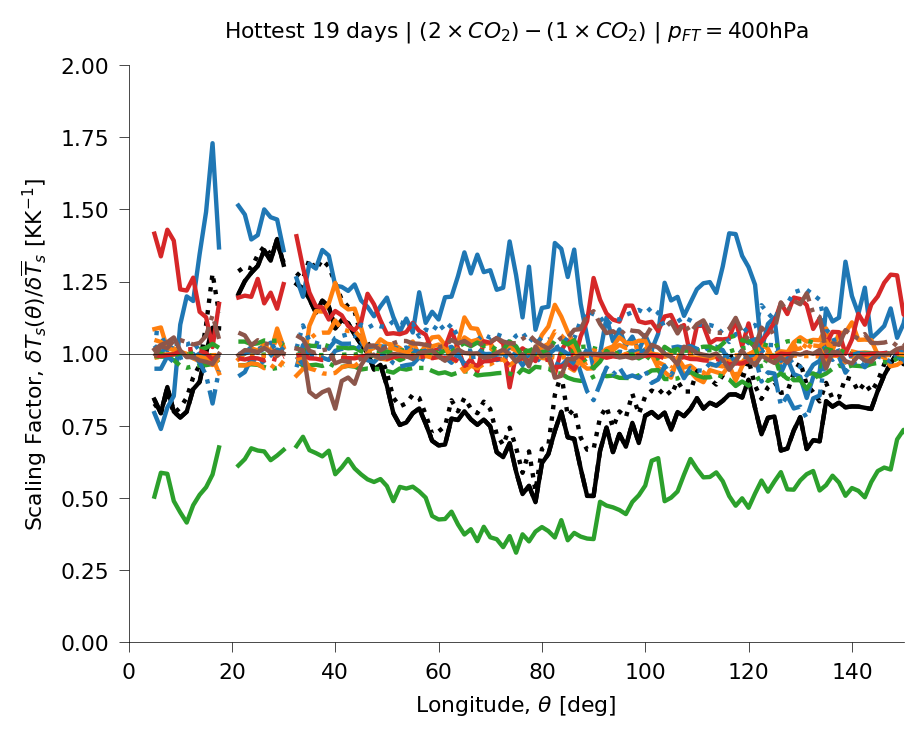

In [324]:
show_non_linear = True

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for key in ['', '_sum', '_linear']:
    ax.plot(ds_out.lon, ds_out[f"scale_factor{key}"],
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label={'': 'Simulated', '_linear': 'Theory - Linear', '_sum': None}[key])
for key in ds_out:
    var = ds_out[key]
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        # Combine non-linear and linear into single mechanism on plot
        if (not show_non_linear) and ('residual' not in key):
            var = var + ds_out[key.replace('nl_', '')] - 1
            key = key.replace('nl_', '')
    elif (not show_non_linear) and ('error_av' not in key):
        continue
    if np.abs(var - 1).max() < 0.1:
        continue
    ax.plot(ds_out.lon, var, label=key,
            color=style_map[key][0], linestyle=style_map[key][1])
update_linewidth(fig)
# ax.legend(ncol=2)
ax.set_ylim(0, 2)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel('Longitude, $\\theta$ [deg]')
ax.set_ylabel("Scaling Factor, $\delta T_s(\\theta)/\delta \overline{T}_s$ [KK$^{-1}$]")
ax.set_title(
    f"Hottest {ds.sample.size} days | $({int(ds.co2[1])} \\times CO_2) - ({int(ds.co2[0])} \\times CO_2)$ | "
    f"$p_{'{FT}'} = {ds_sf.p_ft / 100:.0f}$hPa", y=1.02)
ax.set_xlim(0, 150)
update_fontsize(fig, 5)
plt.show()

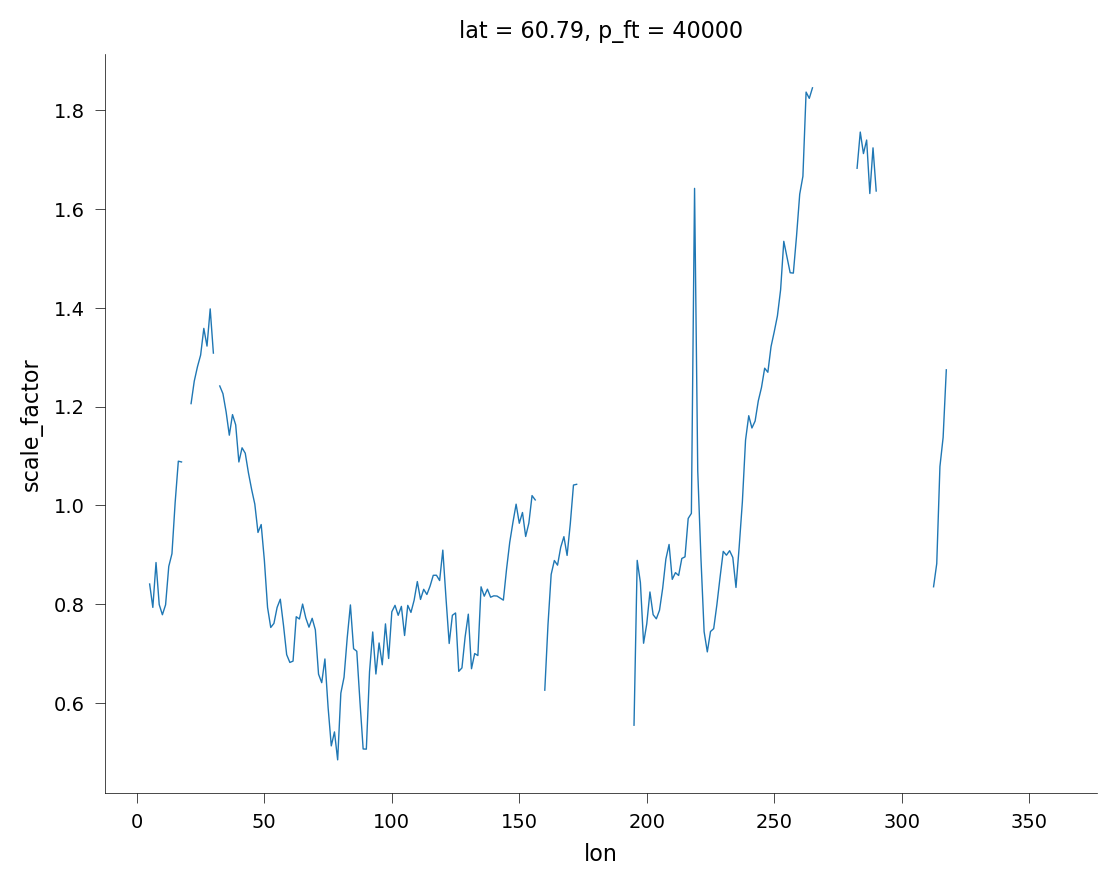

In [318]:
ds_out.scale_factor.plot()

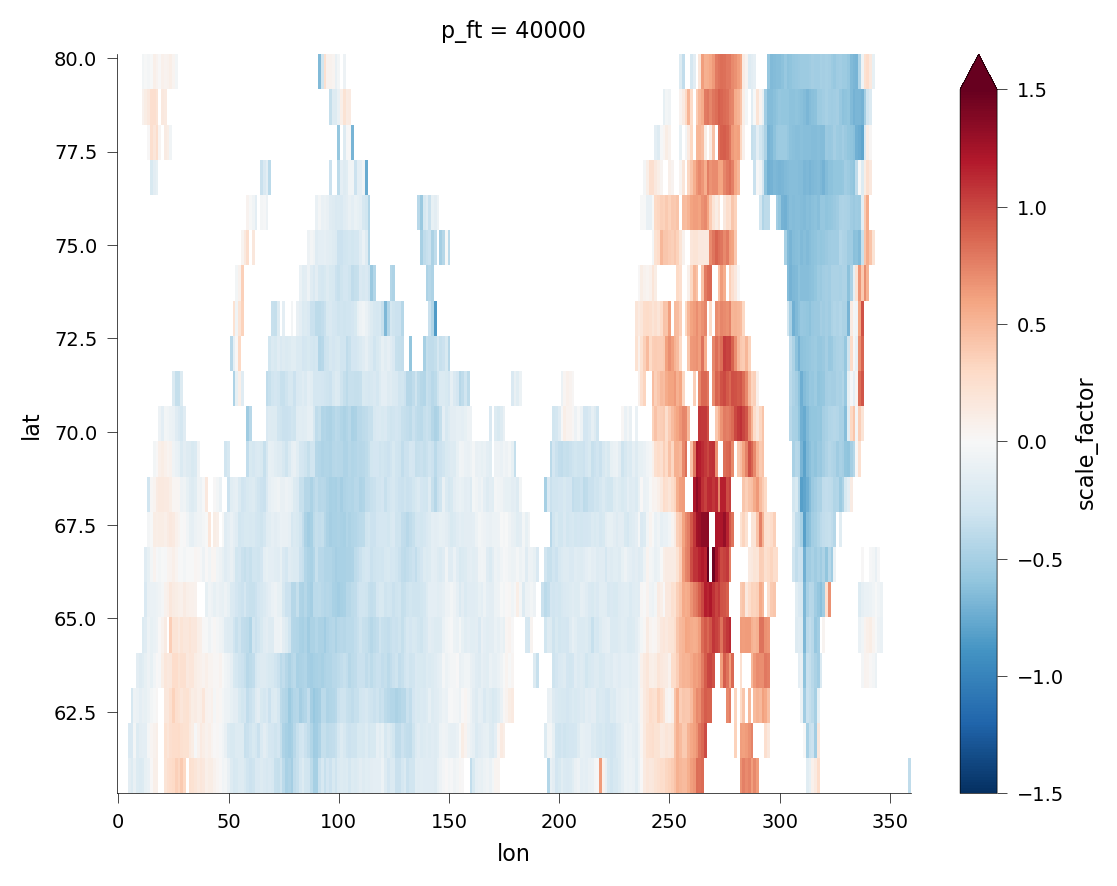

In [287]:
(ds_out.scale_factor-1).plot(vmax=1.5)

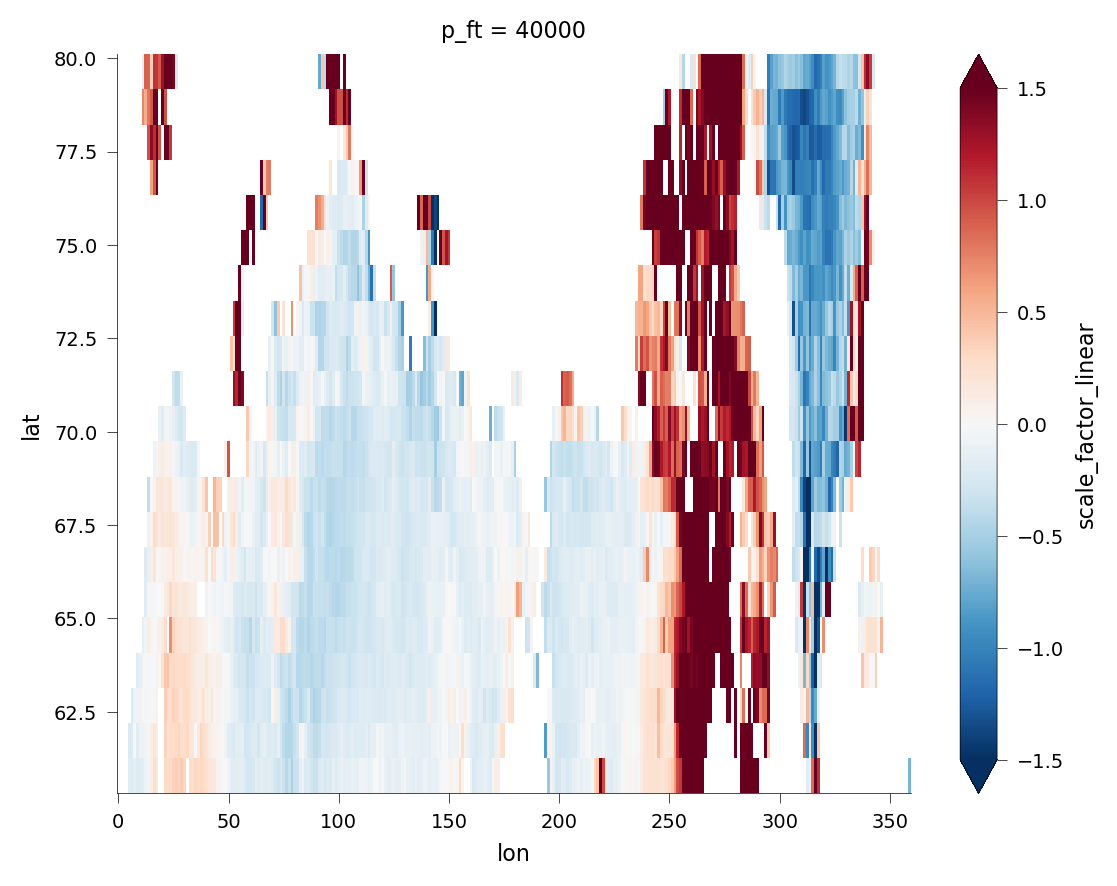

In [288]:
(ds_out.scale_factor_linear-1).plot(vmax=1.5)

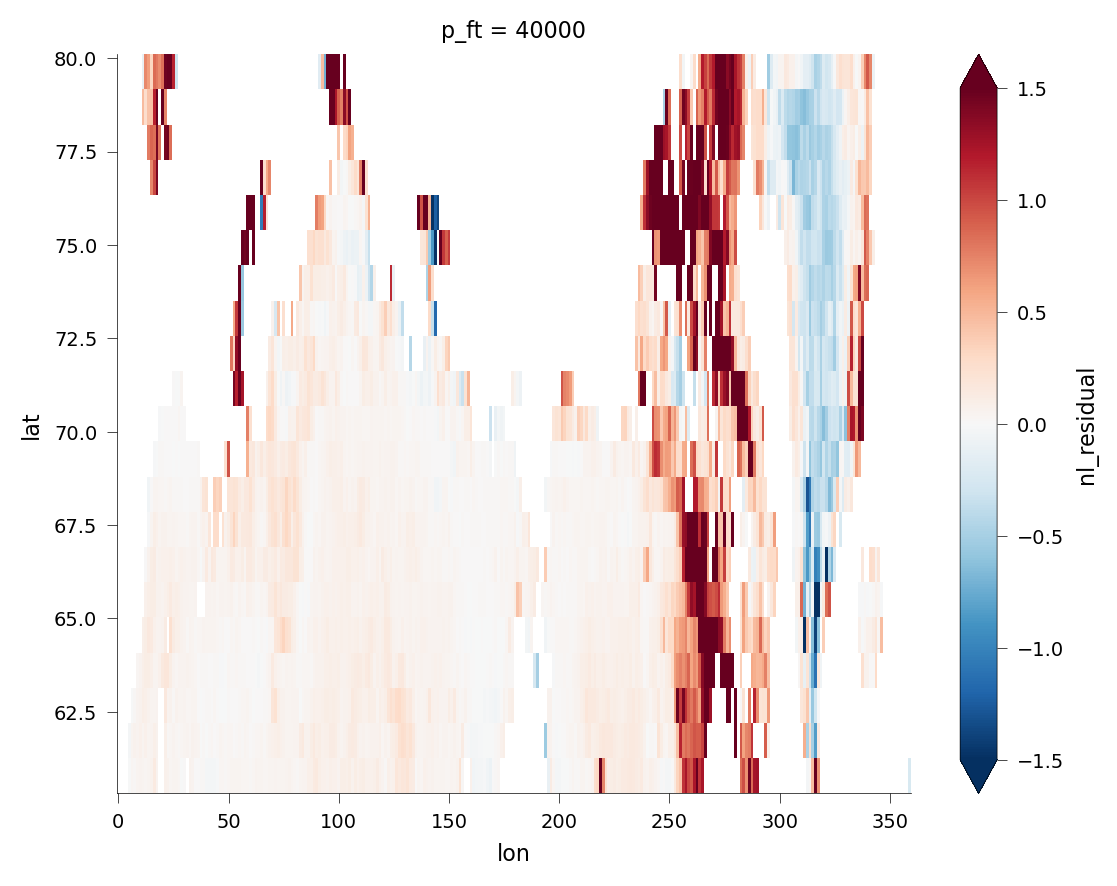

In [289]:
(ds_out.nl_residual-1).plot(vmax=1.5)

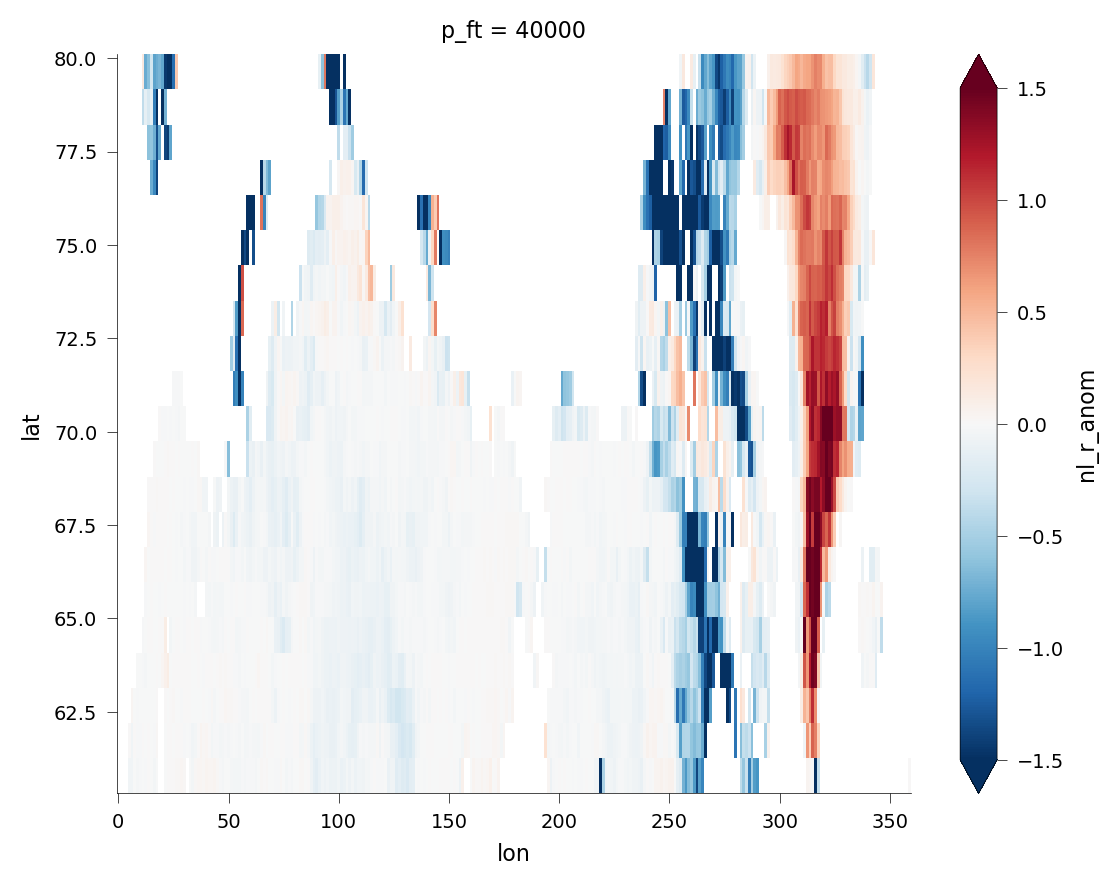

In [284]:
(ds_out.nl_r_anom-1).plot(vmin=-1.5)

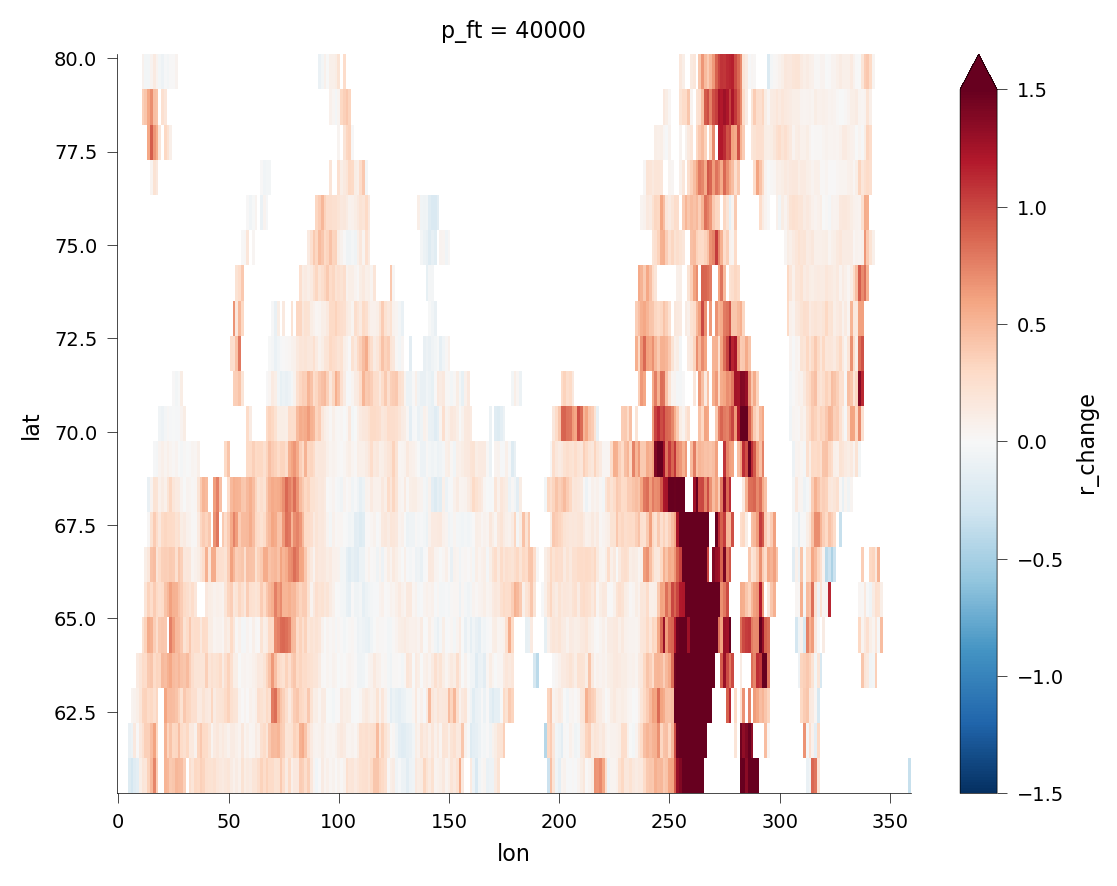

In [278]:
(ds_out.r_change-1).plot(vmin=-1.5)

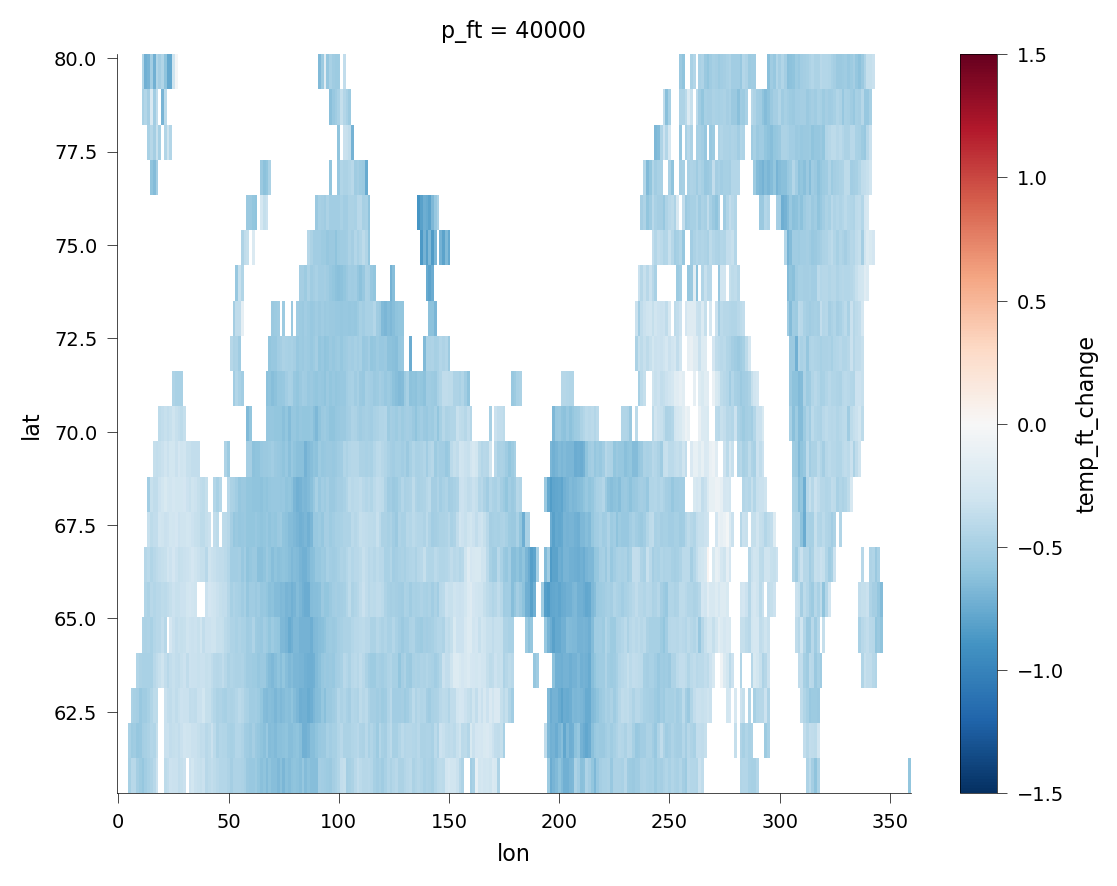

In [291]:
(ds_out.temp_ft_change-1).plot(vmin=-1.5)

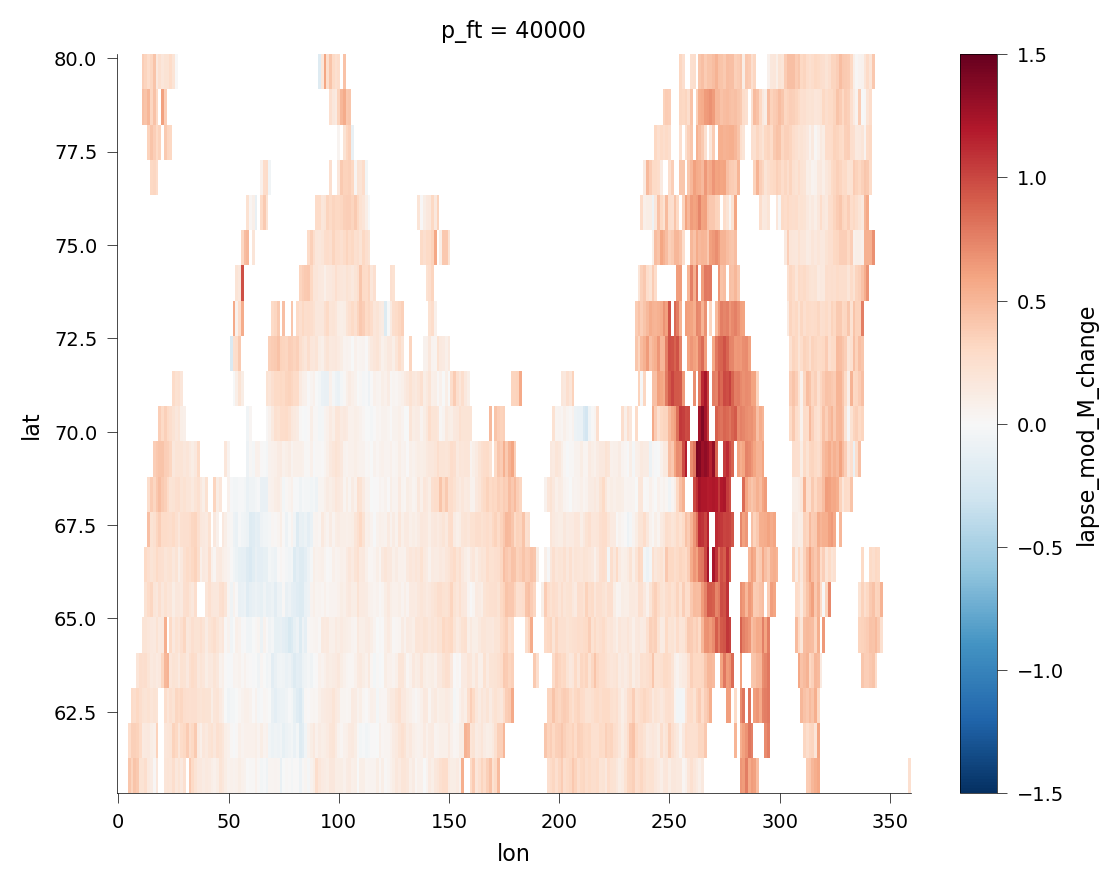

In [269]:
(ds_out.lapse_mod_M_change-1).plot(vmin=-1.5)

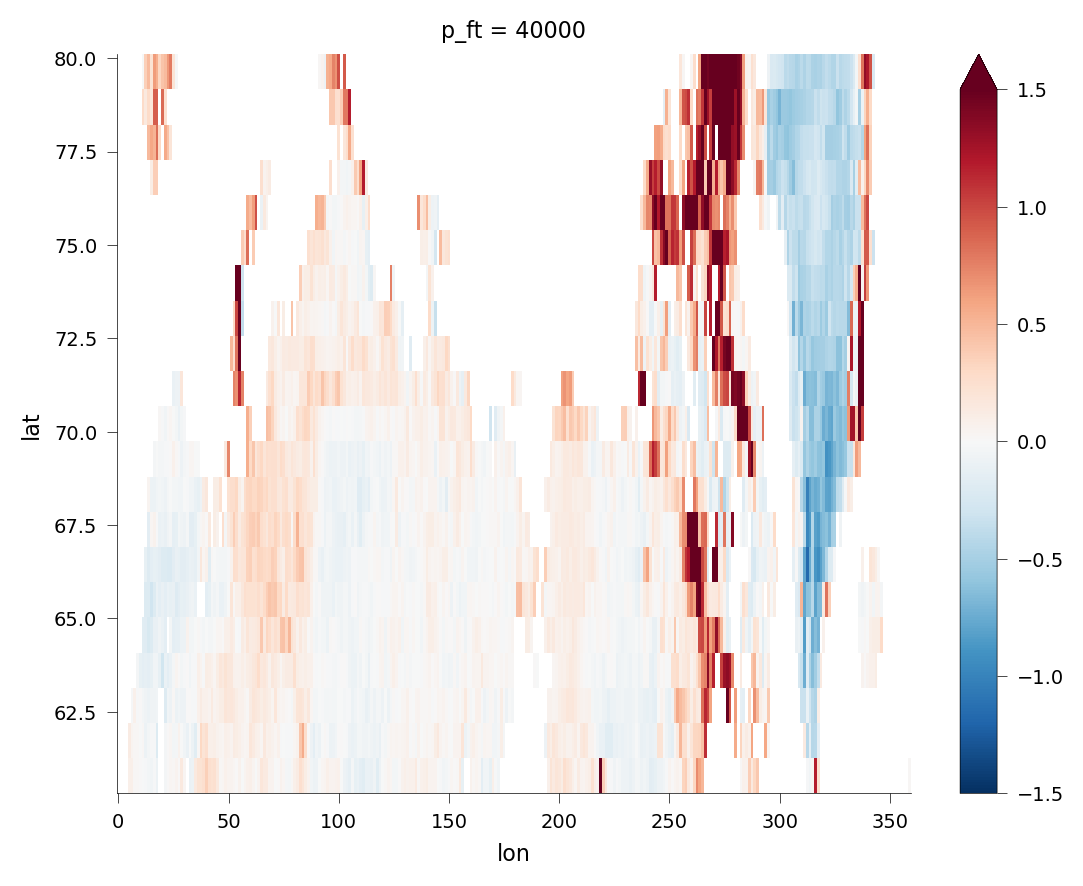

In [286]:
(ds_out.lapse_mod_D_change+ds_out.nl_lapse_mod_D_change-2).plot(vmin=-1.5)